# Deep Q-Learning:
In deep Q-learning, we use a neural network to approximate the Q-value function. The state is given as the input and the Q-value of all possible actions is generated as the output.
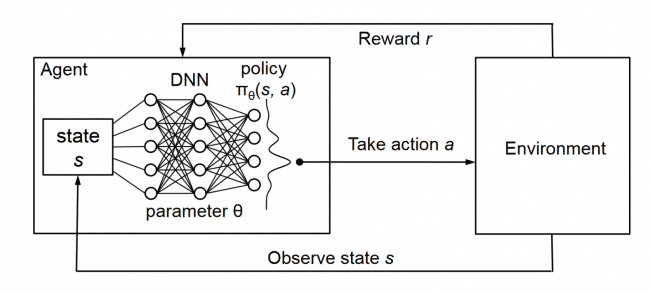

Steps:
1. All the past experience is stored by the user in memory
2. The next action is determined by the maximum output of the Q-network
3. The loss function here is mean squared error of the predicted Q-value and the target Q-value – Q*. 
    This is basically a regression problem. However, we do not know the target or actual value here 
    as we are dealing with a reinforcement learning problem. 
4. Going back to the Q-value update equation derived fromthe Bellman equation.

## Import Libraries:

In [1]:
import time
from time import sleep
import random
from itertools import count
import matplotlib.pyplot as plt

import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY, COMPLEX_MOVEMENT
from nes_py.wrappers import JoypadSpace

import numpy as np

from DeepQ_Network import DQNetwork
from replay_from_memory import ReplayMemory
from wrappers import wrapper


Using TensorFlow backend.


## Setting Hyperparameters:

In [2]:
FRAME_DIM = (84, 84, 4)
ACTION_SPACE = RIGHT_ONLY   # We can also use other action space COMPLEX_MOVEMENT( for left, right, up and down actions)
REPLAY_MEMORY_CAPACITY = 200_000
NUM_EPISODES = 1001
MAX_STEPS_PER_GAME = 1000
GAMMA = 0.99
RENDER_ENVIRONMENT = False

BATCH_SIZE = 128
TRAIN_FREQUENCE = 4  # number of total steps after which the policy model is trained
TARGET_NETWORK_UPDATE_FREQUENCE = 40_000  # number of total steps after which the weights of the policy model are copied to the target model

EXPLORATION_MAX = .8
EXPLORATION_MIN = 0.05
EXPLORATION_STEPS = 1_000_000
EXPLORATION_DECAY = (EXPLORATION_MAX - EXPLORATION_MIN) / EXPLORATION_STEPS

## Tensorflow Video Emedding

In [3]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

## Creating Video

In [4]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = eval_env.step(action_step.action)
            video.append_data(eval_py_env.render())
    return embed_mp4(filename)

# create_policy_eval_video(agent.policy, "trained-agent")

## select next action:
Based of exploration rate select next action 

In [5]:
def get_next_action(state, action_space, current_exploration):
    """Returns the next action."""
    if np.random.rand() < current_exploration:
        return random.randrange(action_space)
    else:
        predicted_q_values = policy_net.model.predict(np.expand_dims(np.asarray(state).astype(np.float64), axis=0),
                                                      batch_size=1)
        return np.argmax(predicted_q_values[0])


## Modeling:
#### Trains the policy net on a batch from the replay memory.

In [6]:
def train_policy_model(replay_memory, policy_model, target_model):

    # if there are not enough transitions yet don't train
    if len(replay_memory) < BATCH_SIZE:
        return

    batch = replay_memory.sample(BATCH_SIZE)

    # get the target q values of the target model
    current_states = []
    target_predictions = []
    for state, action, reward, next_state, done in batch:
        # convert the states
        current_state = np.expand_dims(np.asarray(state).astype(np.float64), axis=0)
        next_state = np.expand_dims(np.asarray(next_state).astype(np.float64), axis=0)

        # get the prediction of the target network and the current policy network
        target_prediction = target_model.predict(next_state)
        target_q_value = np.max(target_prediction)
        current_prediction = policy_model.predict(current_state)[0]

        # calculate the new q values
        if done:
            current_prediction[action] = reward
        else:
            current_prediction[action] = reward + GAMMA * target_q_value

        current_states.append(current_state)
        target_predictions.append(target_prediction)

    # train the policy model based on the predictions of the target model
    policy_model.fit(np.asarray(current_states).squeeze(), np.asarray(target_predictions).squeeze(),
                     batch_size=BATCH_SIZE, verbose=0)


## Check Available GPU:

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib

print(tf.__version__)

def check_GPU():
    local_devices = device_lib.list_local_devices()
    print("local_devices: ", local_devices)
    print("Available GPUs: ", tf.config.experimental.list_physical_devices('GPU'))
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)


check_GPU()


1.15.0
local_devices:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12006859598251084274
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10456358168899386685
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11897235047
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10724935243077615978
physical_device_desc: "device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:04:00.0, compute capability: 6.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13690112305508995353
physical_device_desc: "device: XLA_GPU device"
]
Available GPUs:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPUs


## Train Mario











Episode:  0 reward:  652.0
Episode:  1 reward:  791.0
Episode:  2 reward:  1402.0
Episode:  3 reward:  808.0
Episode:  4 reward:  637.0
Episode:  5 reward:  1041.0
Episode:  6 reward:  1424.0
Episode:  7 reward:  256.0
Episode:  8 reward:  615.0
Episode:  9 reward:  1202.0
Episode:  10 reward:  241.0
Episode:  11 reward:  806.0
Episode:  12 reward:  644.0
Episode:  13 reward:  240.0
Episode:  14 reward:  1011.0
Episode:  15 reward:  782.0
Episode:  16 reward:  1323.0
Episode:  17 reward:  259.0
Episode:  18 reward:  736.0
Episode:  19 reward:  638.0
Episode:  20 reward:  634.0
Episode:  21 reward:  797.0
Episode:  22 reward:  1313.0
Episode:  23 reward:  232.0
Episode:  24 reward:  1046.0
Episode:  25 reward:  236.0
Episode:  26 reward:  1416.0
Episode:  27 reward:  1301.0
Episode:  28 reward:  1005.0
Episode:  29 reward:  1050.0
Episode:  30 reward:  249.0
Episode:  31 reward:  247.0
Episode:  32 reward:  636.0
Episode:  33 reward:  1003.0
Episode:  34 reward:  639.0
Episode

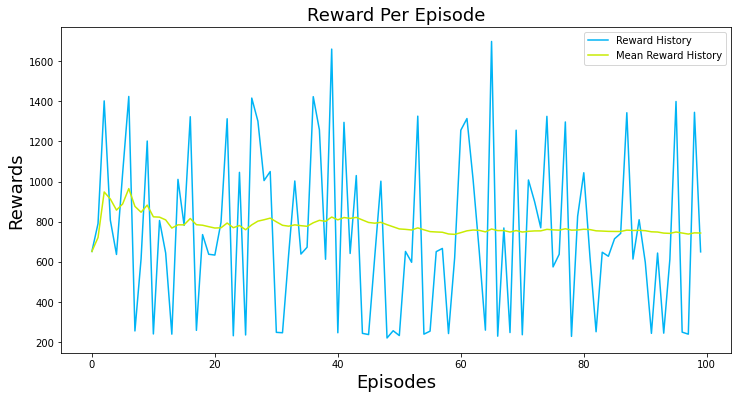

Episode:  100 reward:  787.0
Episode:  101 reward:  1320.0
Episode:  102 reward:  634.0
Episode:  103 reward:  609.0
Episode:  104 reward:  620.0
Episode:  105 reward:  1027.0
Episode:  106 reward:  636.0
Episode:  107 reward:  238.0
Episode:  108 reward:  964.0
Episode:  109 reward:  819.0
Episode:  110 reward:  640.0
Episode:  111 reward:  1012.0
Episode:  112 reward:  258.0
Episode:  113 reward:  622.0
Episode:  114 reward:  615.0
Episode:  115 reward:  248.0
Episode:  116 reward:  617.0
Episode:  117 reward:  611.0
Episode:  118 reward:  774.0
Episode:  119 reward:  758.0
Episode:  120 reward:  586.0
Episode:  121 reward:  626.0
Episode:  122 reward:  806.0
Episode:  123 reward:  736.0
Episode:  124 reward:  625.0
Episode:  125 reward:  708.0
Episode:  126 reward:  592.0
Episode:  127 reward:  1823.0
Episode:  128 reward:  615.0
Episode:  129 reward:  240.0
Episode:  130 reward:  1566.0
Episode:  131 reward:  606.0
Episode:  132 reward:  244.0
Episode:  133 reward:  241.0
Episode: 

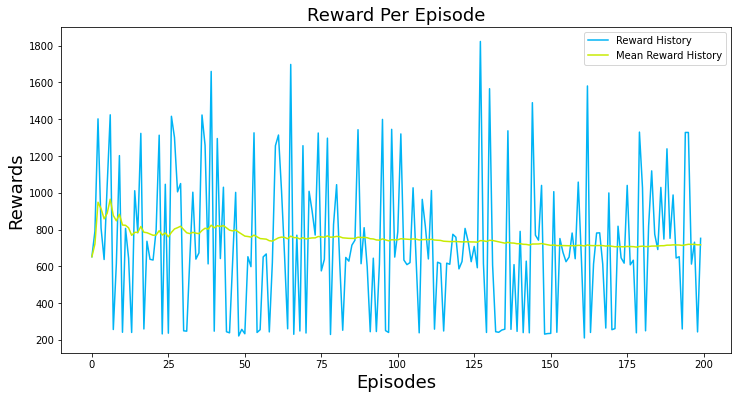

Episode:  200 reward:  608.0
Episode:  201 reward:  797.0
Episode:  202 reward:  629.0
Episode:  203 reward:  231.0
Episode:  204 reward:  613.0
Episode:  205 reward:  654.0
Episode:  206 reward:  1315.0
Episode:  207 reward:  1280.0
Episode:  208 reward:  1008.0
Episode:  209 reward:  249.0
Episode:  210 reward:  813.0
Episode:  211 reward:  1902.0
Episode:  212 reward:  1302.0
Episode:  213 reward:  651.0
Updated the target Model
Episode:  214 reward:  1028.0
Episode:  215 reward:  1326.0
Episode:  216 reward:  1327.0
Episode:  217 reward:  633.0
Episode:  218 reward:  604.0
Episode:  219 reward:  1011.0
Episode:  220 reward:  651.0
Episode:  221 reward:  652.0
Episode:  222 reward:  664.0
Episode:  223 reward:  253.0
Episode:  224 reward:  653.0
Episode:  225 reward:  639.0
Episode:  226 reward:  616.0
Episode:  227 reward:  1316.0
Episode:  228 reward:  615.0
Episode:  229 reward:  973.0
Episode:  230 reward:  628.0
Episode:  231 reward:  824.0
Episode:  232 reward:  819.0
Episode:

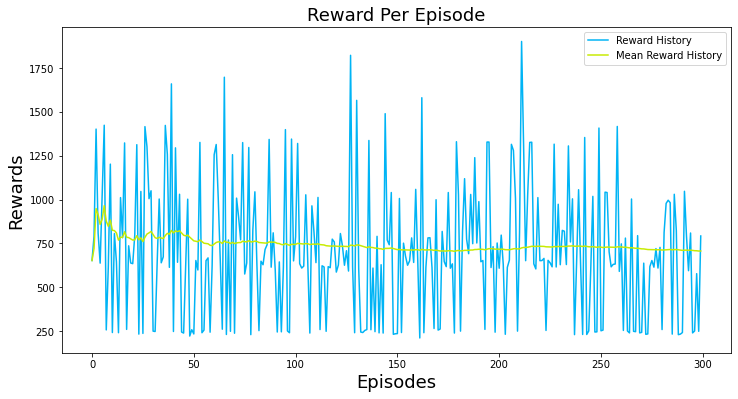

Episode:  300 reward:  247.0
Episode:  301 reward:  652.0
Episode:  302 reward:  246.0
Episode:  303 reward:  701.0
Episode:  304 reward:  648.0
Episode:  305 reward:  638.0
Episode:  306 reward:  1030.0
Episode:  307 reward:  597.0
Episode:  308 reward:  1053.0
Episode:  309 reward:  624.0
Episode:  310 reward:  239.0
Episode:  311 reward:  635.0
Episode:  312 reward:  248.0
Episode:  313 reward:  1337.0
Episode:  314 reward:  625.0
Episode:  315 reward:  1013.0
Episode:  316 reward:  243.0
Episode:  317 reward:  653.0
Episode:  318 reward:  1310.0
Episode:  319 reward:  1053.0
Episode:  320 reward:  258.0
Episode:  321 reward:  635.0
Episode:  322 reward:  619.0
Episode:  323 reward:  809.0
Episode:  324 reward:  623.0
Episode:  325 reward:  637.0
Episode:  326 reward:  1034.0
Episode:  327 reward:  757.0
Episode:  328 reward:  243.0
Episode:  329 reward:  258.0
Episode:  330 reward:  254.0
Episode:  331 reward:  1045.0
Episode:  332 reward:  1049.0
Episode:  333 reward:  800.0
Episo

In [ ]:
env = gym_super_mario_bros.make("SuperMarioBros-v0")
env = JoypadSpace(env, ACTION_SPACE)    # An environment wrapper to convert binary to discrete action space.
# apply the wrapper
env = wrapper(env, FRAME_DIM)

# create the network
policy_net = DQNetwork(stacked_frame_dim=FRAME_DIM, num_actions=env.action_space.n)
target_net = DQNetwork(stacked_frame_dim=FRAME_DIM, num_actions=env.action_space.n)

# create the replay memory
replay_memory = ReplayMemory(REPLAY_MEMORY_CAPACITY)

# play the episodes
current_exploration = EXPLORATION_MAX
total_steps = 0
reward_history = []
mean_reward_history = []
for episode in range(NUM_EPISODES):
    state = env.reset()

    # play one game
    current_reward = 0
    for steps in count(MAX_STEPS_PER_GAME):
        # render the environment
        if RENDER_ENVIRONMENT:
            env.render()

        # get the next action
        action = get_next_action(state, env.action_space.n, current_exploration)

        # perform the action
        next_state, reward, done, info = env.step(action)

        # if we are done end the loop
        if done or info["life"] < 2:
            print("Episode: ", episode, "reward: ", current_reward)
            reward_history.append(current_reward)
            mean_reward_history.append(np.mean(reward_history))
            break

        # add the transition to the replay memory
        replay_memory.push(state, action, reward, next_state, done)

        # increase the current reward and the total steps
        current_reward += reward
        total_steps += 1

        # train the policy network
        if total_steps % TRAIN_FREQUENCE == 0:
            train_policy_model(replay_memory, policy_net.model, target_net.model)

        # update the weights of the target model if necessary
        if total_steps % TARGET_NETWORK_UPDATE_FREQUENCE == 0:
            print("Updated the target Model")
            target_net.model.set_weights(policy_net.model.get_weights())

        # update the exploration rate
        current_exploration -= EXPLORATION_DECAY
        current_exploration = max(EXPLORATION_MIN, current_exploration)

    # plot the reward history
    if (episode + 1) % 100 == 0:
        plt.figure(figsize=(12,6))
        plt.plot(reward_history, "#00b4f5", label = "Reward History")
        plt.plot(mean_reward_history, "#c8eb02", label = "Mean Reward History")
        plt.ylabel("Rewards", fontsize = 18)
        plt.xlabel("Episodes",fontsize = 18)
        plt.title("Reward Per Episode", fontsize = 18)
        plt.legend()
        plt.show()
